# Single and Bi-Tensor models

In [1]:
import os
import os.path
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nibabel as nib

In [2]:
base_filename = "../data/output/S264294/S264294_DTI_gated_20150508093306_12"

fdwi = base_filename + "_fw.nii.gz"
#fdwi = base_filename + "_crop.nii.gz"
#fdwi = base_filename + "_syn.nii.gz"

fbval = base_filename + ".bval"
fbvec = base_filename + ".bvec"


def default_plot_3d_z_indices(arr, idx_list=range(0,10,2), transpose=True, 
                              num_rows=2, num_cols=3):
    fig = plot_3d_z_indices(arr, idx_list=idx_list, transpose=transpose, 
                      num_rows=num_rows, num_cols=num_cols)


In [3]:
img = nib.load(fdwi)
data = img.get_data()

from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [4]:
print("\nData Shape:", data.shape)
print("\nImage Zooms:", img.header.get_zooms()[:3])
print("\ngtab Info:")
gtab.info
print("\ngtab bvalues:\n", gtab.bvals) # b values
# First few gradient directions
print("\ngtab vecs:\n", gtab.bvecs[:10, :])


Data Shape: (51, 43, 9, 65)

Image Zooms: (1.9827586, 1.9827586, 2.0)

gtab Info:
B-values shape (65,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (65, 3)
         min -0.964118 
         max 0.999988 

gtab bvalues:
 [   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]

gtab vecs:
 [[ 0.          0.          0.        ]
 [ 0.999975   -0.00504502 -0.00503994]
 [ 0.          0.999988   -0.00497989]
 [-0.0249489   0.65464    -0.755529  ]
 [ 0.589353   -0.769866   -0.244886  ]
 [-0.235876   -0.529835   -0.81464   ]
 [-0.893575   -0.264756   -0.36253   ]
 [ 0.797989    0.133987   -0.58759   ]
 [ 0.232856    0.932211   -0.277056  ]

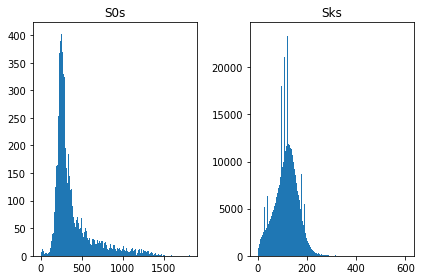

In [5]:
#histogram of the S0 values (b0 image)
S0s = data[:, :, :, gtab.b0s_mask]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.hist(S0s.ravel(), 500)
ax1.set_title("S0s")
ax2.hist(data[:, :, :, ~gtab.b0s_mask].ravel(), 500)
ax2.set_title("Sks")
plt.tight_layout()

The S0 values look nicely bimodal. The S_k values look gaussian with wierd spikes. Are these from eddy currents or head motion?

# Single Compartment model

In [6]:
import dipy.reconst.dti as dti
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

### Fractional Anisotropy

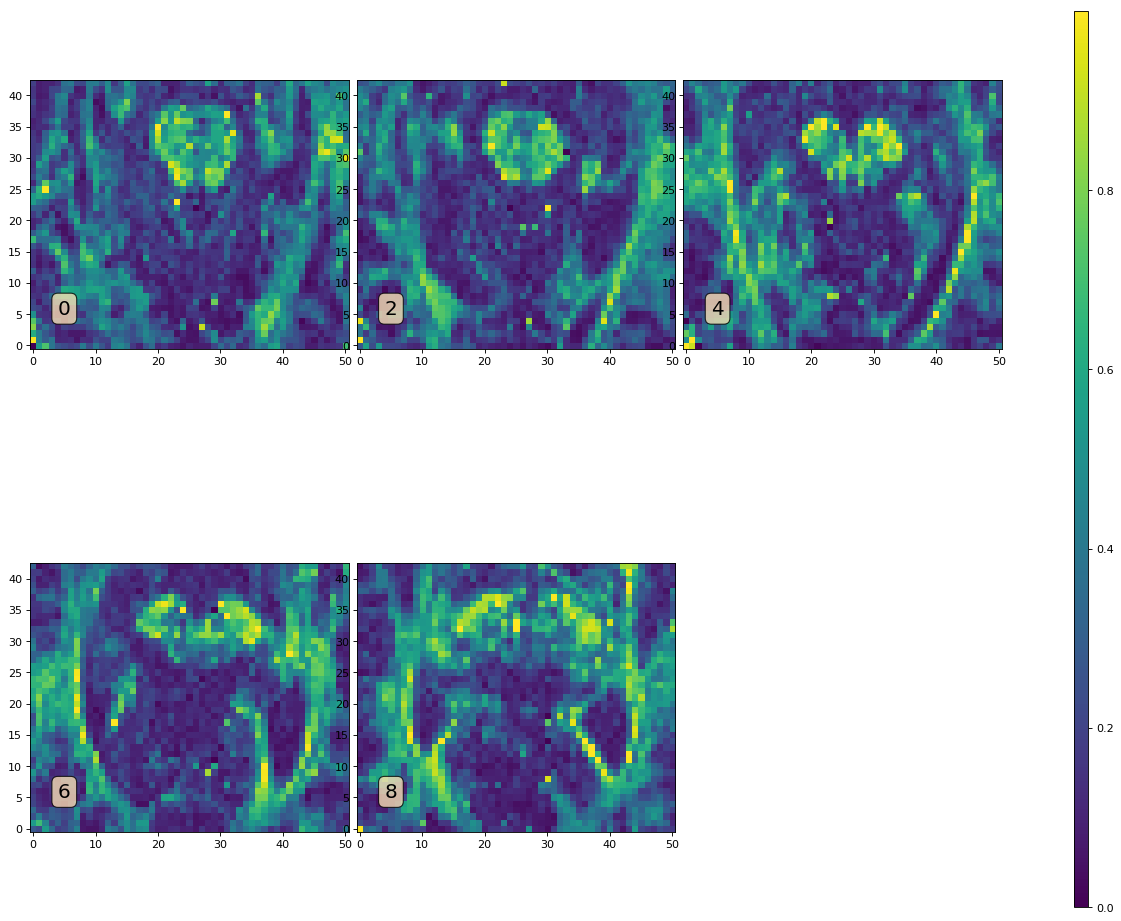

In [7]:
FA = dti.fractional_anisotropy(tenfit.evals)
default_plot_3d_z_indices(FA)

# Mean Diffusivity

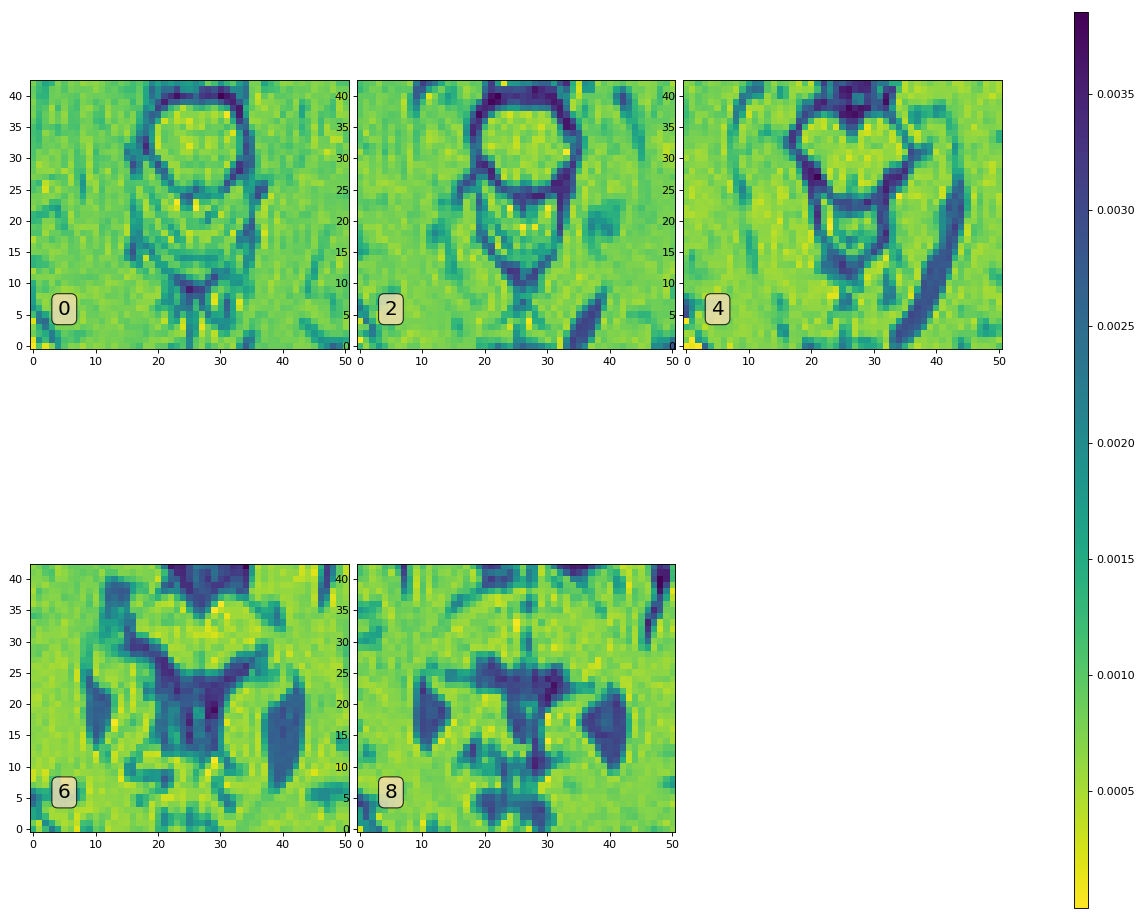

In [8]:
MD = dti.mean_diffusivity(tenfit.evals)
plt.set_cmap("viridis_r")
# Plot the MD for a few z-indices
default_plot_3d_z_indices(MD)

# Bi-tensor Model (Free Water)

In [9]:
ADC_water = 3 * 1e-3
b_value = gtab.bvals[1]
Awater_scalar = np.exp(- b_value * ADC_water)
print("Awater_k = %.2f" % Awater_scalar)

Awater_k = 0.05


Make sure there are no zeros in our signal and everything is positive

In [10]:
data_bi = data.astype(np.float_, copy=True)
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))
data_bi[data_bi <= 0] = dti.MIN_POSITIVE_SIGNAL
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000000, Max=1815.000000
Min = 0.000100, Max=1815.000000


In [11]:
S0s_bi = data_bi[:,:,:,gtab.b0s_mask]
# Attenuations
Ahat = data_bi.copy() # attenuations
Ahat = Ahat / S0s_bi  

In [12]:
max_diffusivity = 5e-3
attenuation_min = np.exp(- b_value * max_diffusivity )

min_diffusivity = 0.01 * 1e-3
attenuation_max = np.exp(-b_value * min_diffusivity)

print("Attenuation_min = %.3f, Attenuation_max = %.3f" % 
      (attenuation_min, attenuation_max))

Attenuation_min = 0.007, Attenuation_max = 0.990


In [13]:
#Clip the attenuations to attenuation_min and attenuation_max
mask = Ahat < attenuation_min
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat < attenuation_min] = attenuation_min

mask = Ahat > attenuation_max
mask[:,:,:, gtab.b0s_mask] = False
Ahat[Ahat > attenuation_max] = attenuation_max

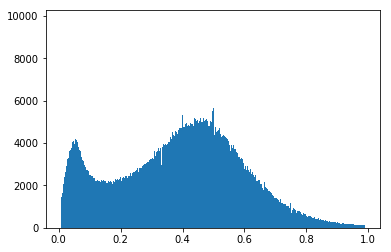

In [14]:
x = plt.hist(Ahat[:,:,:, ~gtab.b0s_mask].ravel(), bins=500)

## Initialization of Free Water Map

Fraction of Data Selected = 0.05


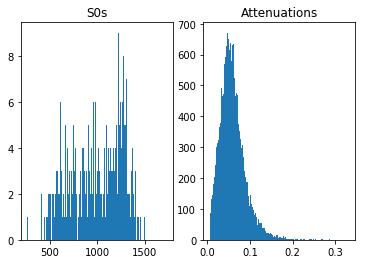

In [15]:
# look at the distribution of voxels in the b0 image that are near 3*1e-3 mm^2/s
mask = np.abs(MD - 3 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
ax1.hist(S0s_bi[mask].ravel(), bins=500)
ax1.set_title("S0s")
# Lets look at the attentuation when the FA is close to that of water
ax2.hist(Ahat[:,:,:,~gtab.b0s_mask][mask].ravel(), bins=500)
x=ax2.set_title("Attenuations")

In [16]:
#Lets set the value of Swater to be 1500 as that is close 
# to the end of the distribution in percentile terms
Swater = 1500 

Fraction of Data Selected = 0.52


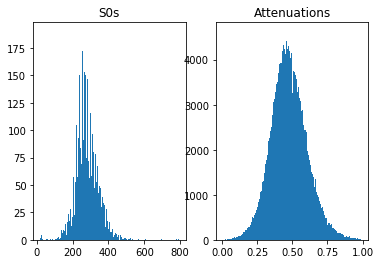

In [17]:
# look at the distribution of voxels that are near 0.8*1e-3 mm^2/s
mask = np.abs(MD - 0.8 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
ax1.hist(S0s_bi[mask].ravel(), bins=500)
ax1.set_title("S0s")
# Lets look at the attentuation when the FA is close to that of 
# white matter 
ax2.hist(Ahat[:,:,:,~gtab.b0s_mask][mask].ravel(), bins=500)
x=ax2.set_title("Attenuations")

In [18]:
# Lets set the value of Stissue to be 200 as that is close
# to the start of the distribution above in percentile terms
Stissue = 200

In [19]:
#Initial free water map

#looking at the distribution of mean diffusivities we can set
lambda_max = 1 * 1e-3 # max diffusivity in tissue
lambda_min = 0.3 * 1e-3 # min diffusivity in tissue

# Max and min attenuation. (Amax uses lambda_min and vice versa)
Amax = np.exp(-b_value * lambda_min)
Amin = np.exp(-b_value * lambda_max)

print("Amin=%.2f, Amax = %.2f" % (Amin, Amax))

Ahat_min = Ahat[..., ~gtab.b0s_mask].min(axis=3)
Ahat_max = Ahat[...,~gtab.b0s_mask].max(axis=3)

print("Ahat_min.shape = %s" % str(Ahat_min.shape))
print("Ahat_max.shape = %s" % str(Ahat_max.shape))

# Note this formula is perhaps a correction of Equation [6]
fmin = (Ahat_min - Awater_scalar) / (Amax - Awater_scalar)
fmax = (Ahat_max - Awater_scalar) / (Amin - Awater_scalar)

print("fmin.shape = %s" % str(fmin.shape))
print("fmax.shape = %s" % str(fmax.shape))

idx = (20, 25, 6)
print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# now make sure fmax and fmin are between 0 and 1

print("fmin.max = %.2f, fmin.min=%.2f" % (fmin.max(), fmin.min()))
fmin[fmin <= 0] = 0.01
fmin[fmin >= 1] = 0.99
print("fmin.max = %.2f, fmin.min=%.2f" % (fmin.max(), fmin.min()))


print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))
fmax[fmax <= 0] = 0.01
fmax[fmax >= 1] = 0.99
print("fmax.max = %.2f, fmax.min=%.2f" % (fmax.max(), fmax.min()))

print("Ahat_min=%.2f, Ahat_max=%.2f, fmax=%.2f, fmin=%.2f" % 
      (Ahat_min[idx], Ahat_max[idx], fmax[idx], fmin[idx]))

# FIXME: setting fmin to 0 and fmax to 1
#fmin[...] = 0 + 0.00001
#fmax[...] = 1 - 0.00001

f_init = 1 - (np.log(np.squeeze(S0s_bi) / Stissue) / np.log(Swater / Stissue))
print("f_init.shape = %s" % str(f_init.shape))
mask = f_init < fmin
f_init[mask] = (fmin[mask] + fmax[mask])/2
mask = f_init > fmax
f_init[mask] = (fmin[mask] + fmax[mask])/2

f_init = f_init[:,:,:,np.newaxis]

# This is our starting value of f
print("f_init.shape = %s" % str(f_init.shape))
print("f_init.max = %.2f, f_init.min=%.2f" % (f_init.max(), f_init.min()))

Amin=0.37, Amax = 0.74
Ahat_min.shape = (51, 43, 9)
Ahat_max.shape = (51, 43, 9)
fmin.shape = (51, 43, 9)
fmax.shape = (51, 43, 9)
Ahat_min=0.01, Ahat_max=0.12, fmax=0.22, fmin=-0.06
fmin.max = 1.36, fmin.min=-0.06
fmin.max = 0.99, fmin.min=0.00
fmax.max = 2.96, fmax.min=-0.01
fmax.max = 1.00, fmax.min=0.01
Ahat_min=0.01, Ahat_max=0.12, fmax=0.22, fmin=0.01
f_init.shape = (51, 43, 9)
f_init.shape = (51, 43, 9, 1)
f_init.max = 0.99, f_init.min=0.01


f_init.max = 0.99
Ahat.max = 0.99
b_value = 1000.00
Cwater.max = 0.05
Cwater.shape:  (51, 43, 9, 1)
Ahat_tissue.shape: (51, 43, 9, 65)


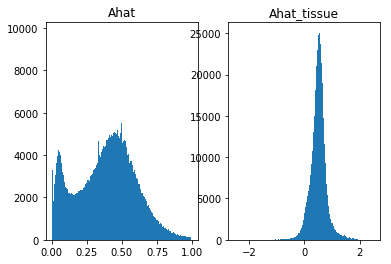

In [20]:
print("f_init.max = %.2f" % f_init.max())
print("Ahat.max = %.2f" % Ahat.max())

Cwater = (1 - f_init) * Awater_scalar
print("b_value = %.2f" % b_value)
print("Cwater.max = %.2f" % Cwater.max())
print("Cwater.shape: ", Cwater.shape)

Ahat_tissue = (Ahat - Cwater) / f_init
print("Ahat_tissue.shape:", Ahat_tissue.shape)

attenuations = Ahat_tissue[:,:,:,~gtab.b0s_mask]
np.clip(attenuations, a_min=-2.5, a_max=2.5, out=attenuations)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
ax1.hist(Ahat[:,:,:,~gtab.b0s_mask].ravel(), 500)
ax1.set_title("Ahat")
ax2.hist(attenuations.ravel(), 500)
x=ax2.set_title("Ahat_tissue")

In [21]:
from freewater import FreeWaterGradientDescent, create_feature_spatial_manifold
from freewater import convert_manifold_to_lower_tri_order
from tracer import LossTracer, IdxTracer

In [22]:
manifold = create_feature_spatial_manifold(S0s, tenfit.quadratic_form)
num_gradients = np.sum(~gtab.b0s_mask)
dt = 0.001 / (b_value * num_gradients)
#dt *= 300000
dt *= 3.

f_init_copy = f_init.copy()
#f_init_copy[...] = 1.
fw_gd = FreeWaterGradientDescent(Ahat, manifold, f_init_copy, gtab, b_value, dt, 
                                 fmin=fmin, fmax=fmax )

fw_gd.beta=100000.

#idx_tracer = IdxTracer((5, 5, 5, Ellipsis), "f,finc,loss_fid,x4inc,x4m")
idx_tracer = IdxTracer((5, 5, 5, Ellipsis))
idx = idx_tracer.idx
loss_tracer = LossTracer()
fw_gd.init_tracers([loss_tracer, idx_tracer])
#fw_gd.init_tracers([loss_tracer])


fw_gd.alpha_fid = 1.
fw_gd.alpha_reg = 1.
fw_gd.alpha_f = 1.


if 1:
    num_iterations = 1000
    for i in range(num_iterations):
        fw_gd.iterate()
    fw_gd.finalize()


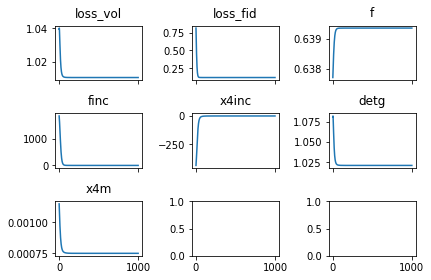

In [23]:
idx_tracer.plot_separate()

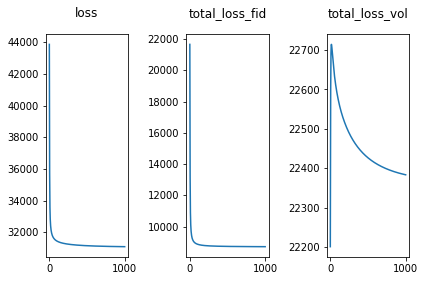

In [24]:
loss_tracer.plot_separate()

### Mean Diffusivity (free water corrected)

In [25]:
#Calculate MD from free water corrected maps. 
from dipy.reconst.dti import decompose_tensor, from_lower_triangular
lower_tri = convert_manifold_to_lower_tri_order(fw_gd.manifold)
evals, evecs = decompose_tensor(from_lower_triangular(lower_tri), min_diffusivity=0.)
MD_fw = evals.mean(axis=-1)

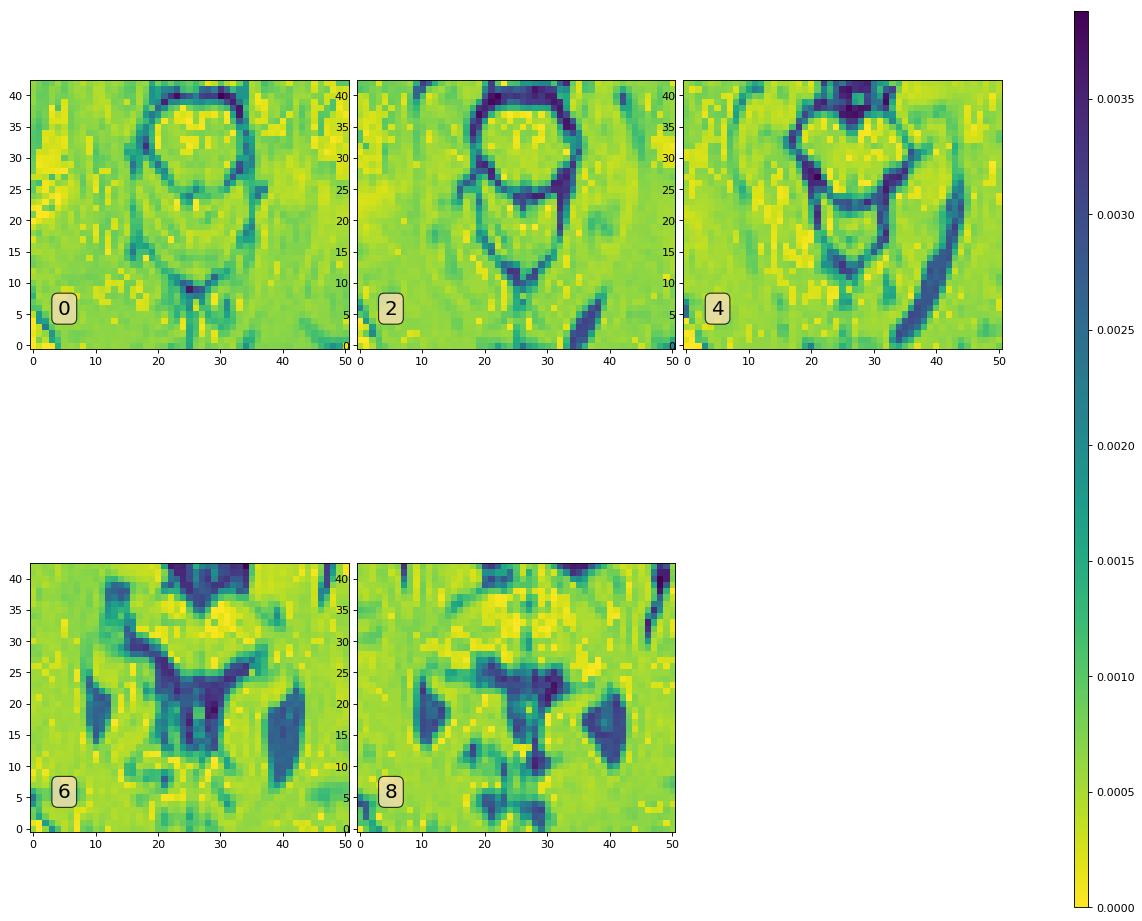

In [26]:
# Mean Diffusion after free water correction
plt.set_cmap("viridis_r")
default_plot_3d_z_indices(MD_fw)

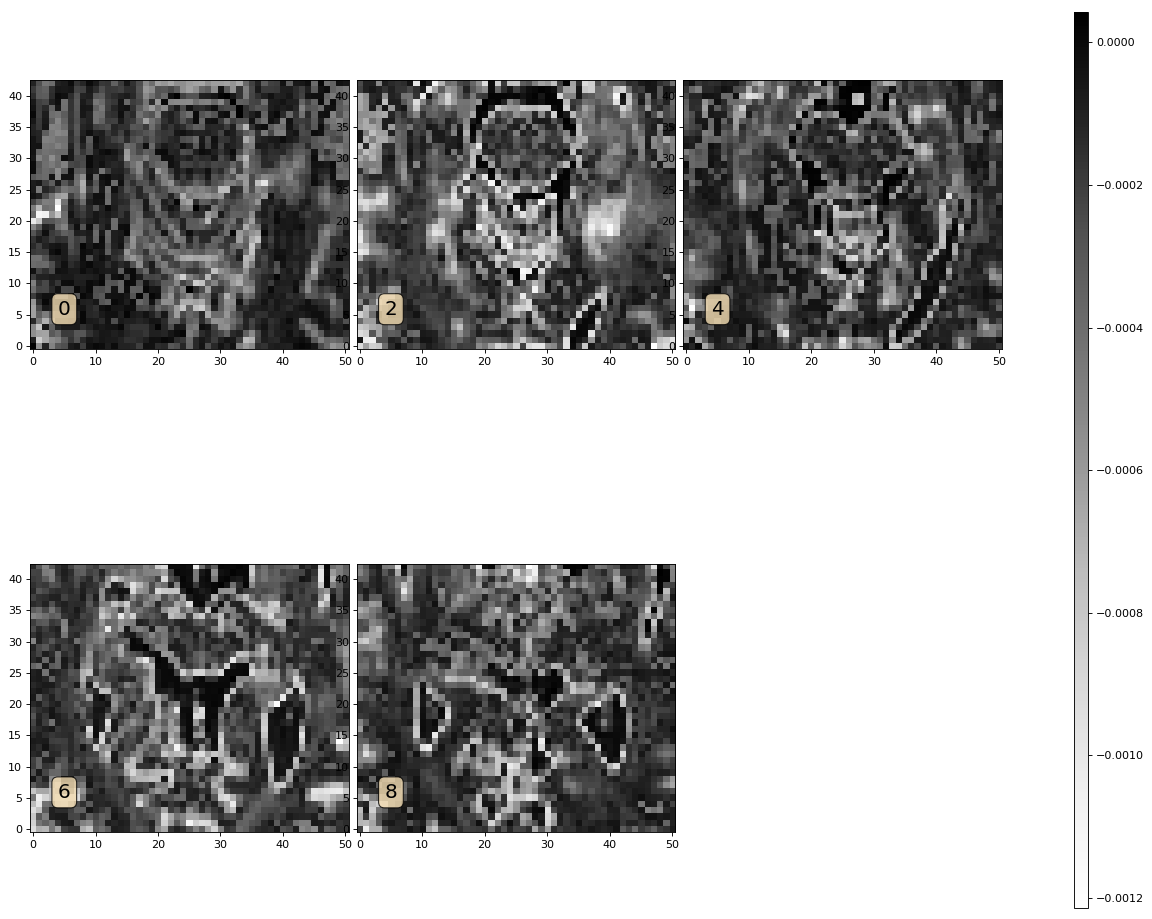

In [27]:
# Difference in Mean Diffusion betweeen Single Compartment and BiTensor Model
plt.set_cmap("Greys")
default_plot_3d_z_indices(MD_fw - MD)

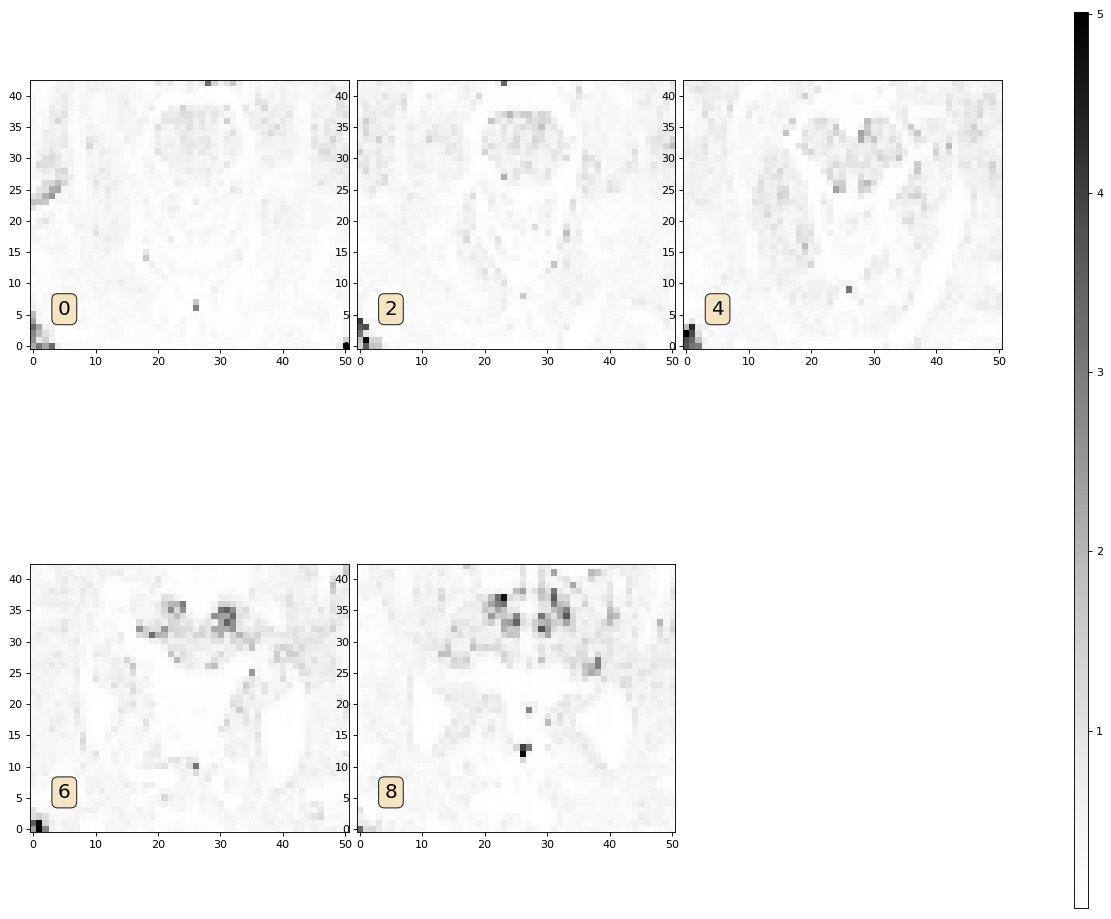

In [28]:
# Loss maps for the fidelity part of the Loss functional
plt.set_cmap("Greys")
default_plot_3d_z_indices(fw_gd.loss_fid)

### Free Water Map

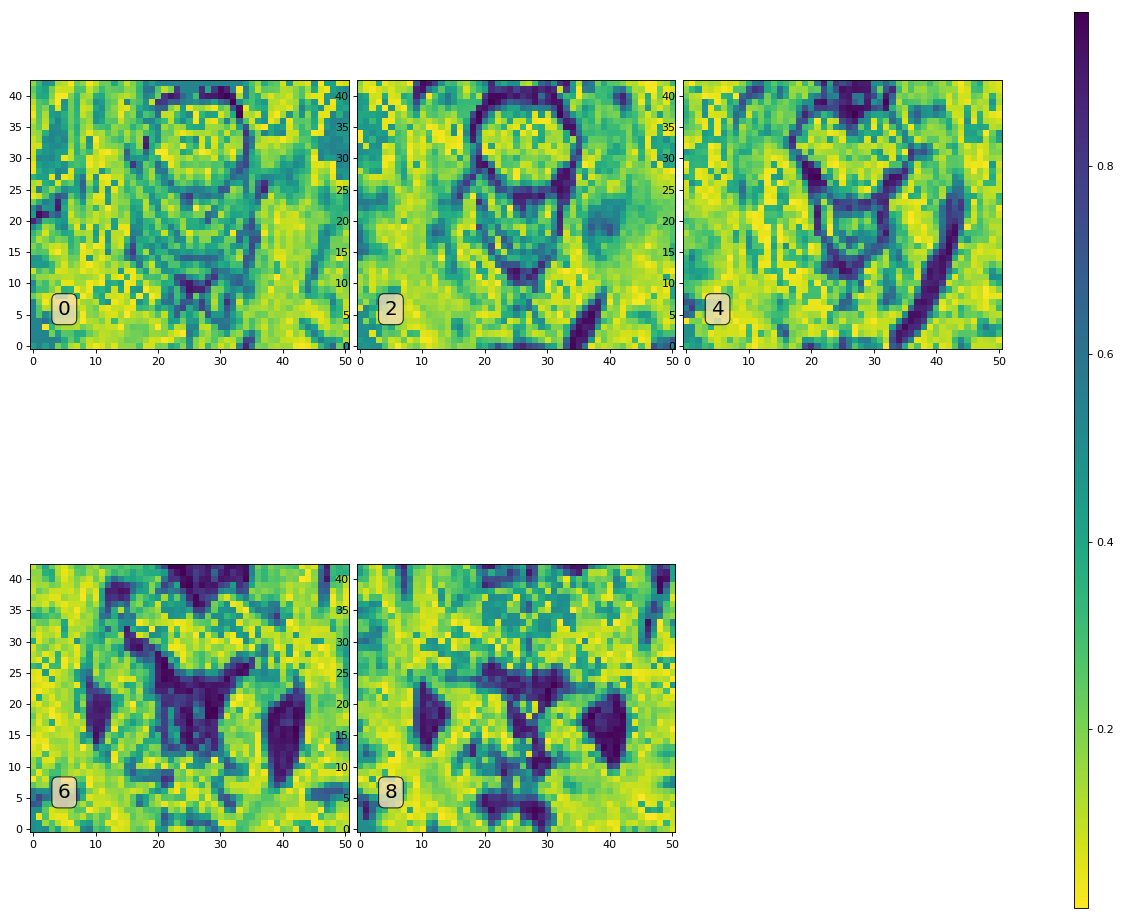

In [29]:
# free water map after iterations
plt.set_cmap("viridis_r")
default_plot_3d_z_indices(1 - fw_gd.f)

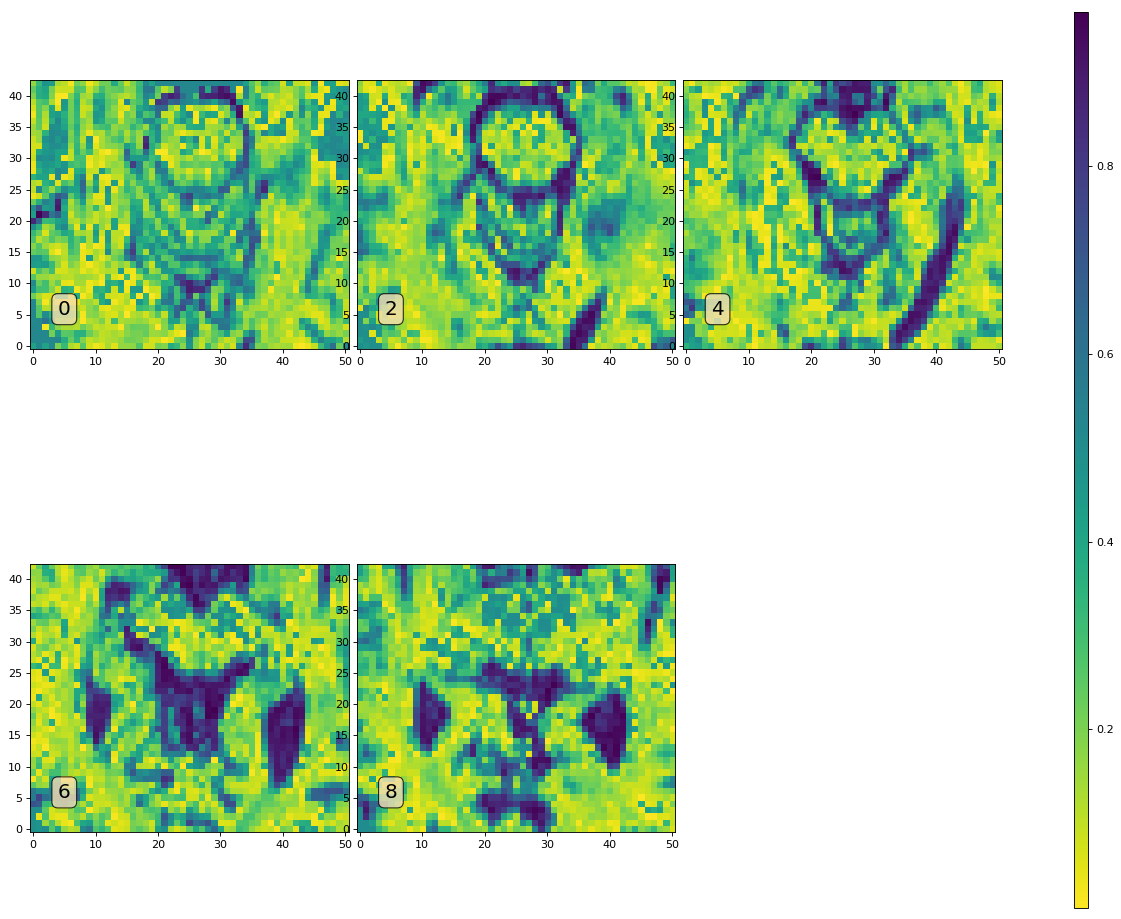

In [30]:
# initial Free water map
plt.set_cmap("viridis_r")
default_plot_3d_z_indices(1 - fw_gd.f_init)

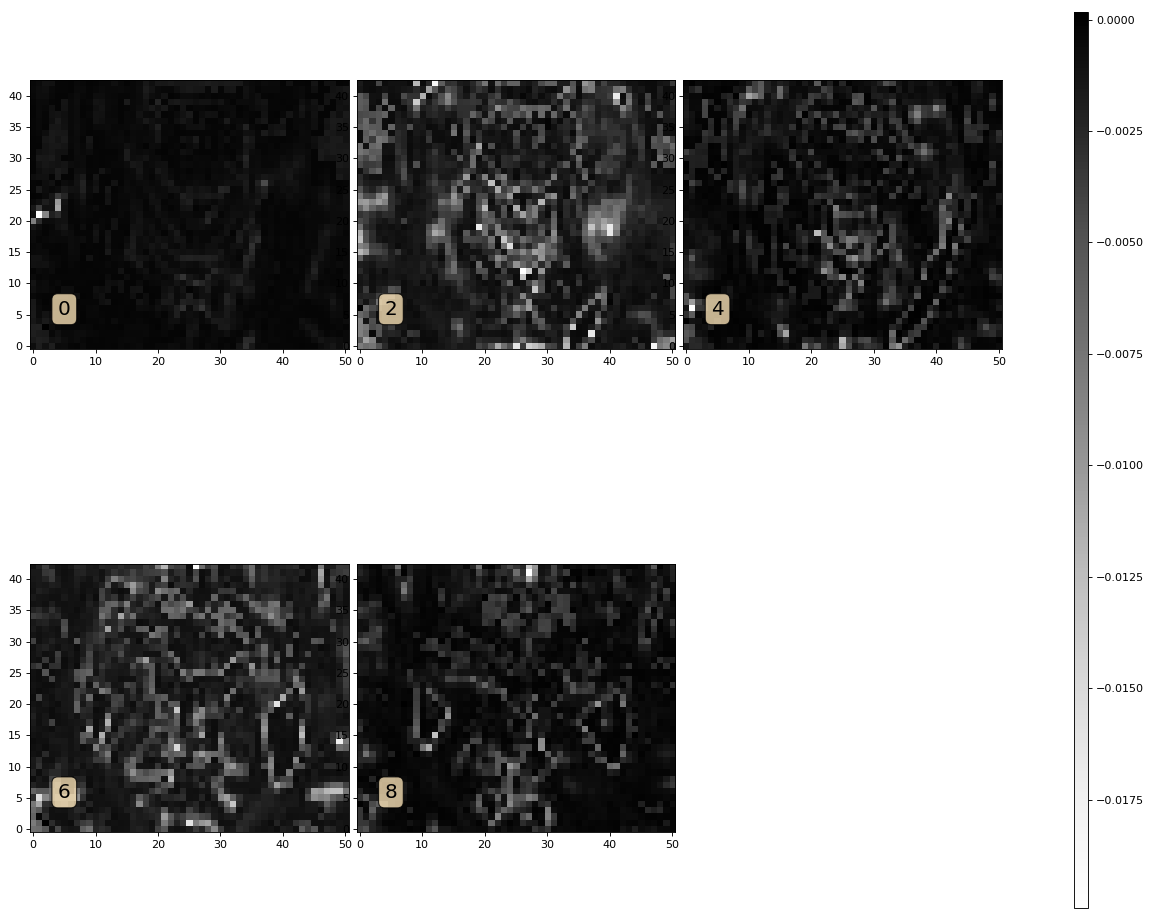

In [31]:
# Difference in free water map from Initial guess.
plt.set_cmap("Greys")
default_plot_3d_z_indices((1 - fw_gd.f) - (1 - fw_gd.f_init))

In [32]:
# save free water output to file
fw_file = base_filename + ".fw.nii.gz"
nib.save(nib.Nifti1Image((1 - fw_gd.f).squeeze(), img.affine), fw_file)